# Practical work 5: edge detection

The goal of this practial work is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [1]:
# Useful modules
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import math

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int(3*sigma)
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()

def subSample2(I):
    """ Array -> Array
    retourne une image à l'aquelle on a enlevé un pixel sur deux"""
    return I[::2,::2]

def imagePad(I, h):  
    """ Array*Array -> Array 
    Réalise un zéro padding d'une image
    """
    N=math.ceil((len(h[1])-1) / 2)
    x,y=I.shape
    xn=x+2*N
    yn=y+2*N
    padding=np.zeros((xn,yn))
    padding[N:xn-N,N:yn-N]=I[:,:]
    return padding

## Exercice 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [2]:
def SobelDetector(I, s):
    """ Array*double -> Array """
    """ Array*float -> Array[bool] """
    
    Sobelx=np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    Sobely=Sobelx.T
    norme=np.sqrt(convolve2d(I,Sobelx, mode="same")**2+convolve2d(I,Sobely, mode="same")**2)
    return norme>s

2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [3]:
def LaplacianDetector(I, s):
    """ Array*double -> Array """
    Laplace = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    height, width = I.shape
    Il = convolve2d(I,Laplace, mode="same")
    J=np.zeros(I.shape)
    Il=np.pad(Il,1)
 
    for i in range(1, height):
        for j in range(1, width):
            mini=255
            maxi=0
            for k in range(0, 3):
                for l in range(0, 3):
                    mini=min(mini,Il[i-1+k, j-1+l])
                    maxi=max(maxi,Il[i-1+k, j-1+l])
            if( (maxi > 0) and (mini < 0) and ((maxi - mini) > s)):
                J[i,j] = True
            else:
                J[i,j] = False
    return J>0 

3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.png`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

In [4]:
lena= np.array(Image.open("img/lena.png"))

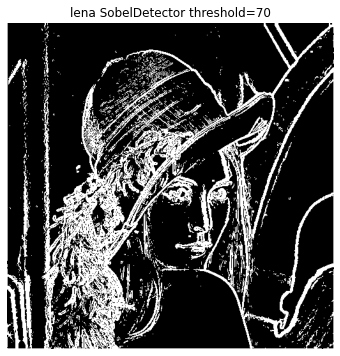

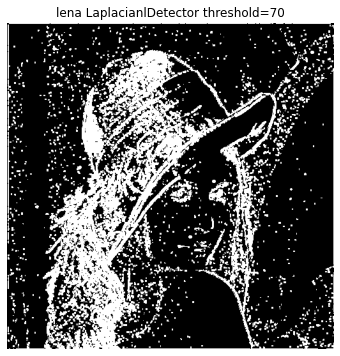

In [5]:
sLena = SobelDetector(lena, 70)
imshow(sLena,"lena SobelDetector threshold=70")
lLena = LaplacianDetector(lena, 70)
imshow(lLena,"lena LaplacianlDetector threshold=70")

## Exercice 2: Non maximum suppression

This exercice addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using your favorite filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.png`. Verify values according to the different local orientation configurations (use `imshow_hot()` in interactive mode in the nootebook to see pixels value pointed by the mouse screen).

<IPython.core.display.Javascript object>


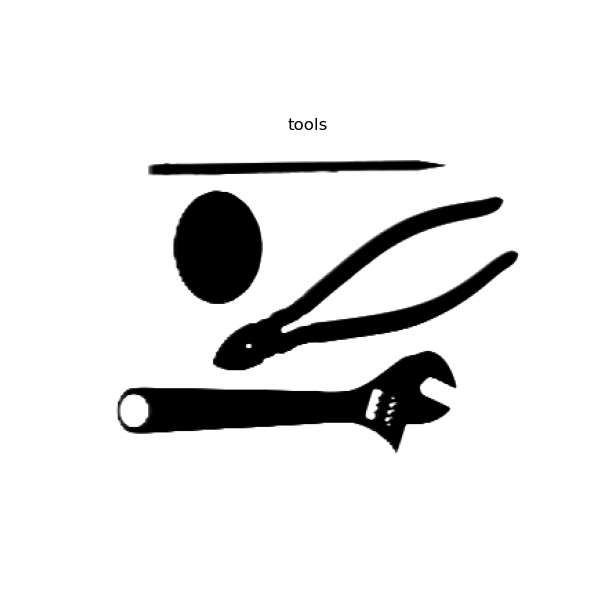

<IPython.core.display.Javascript object>


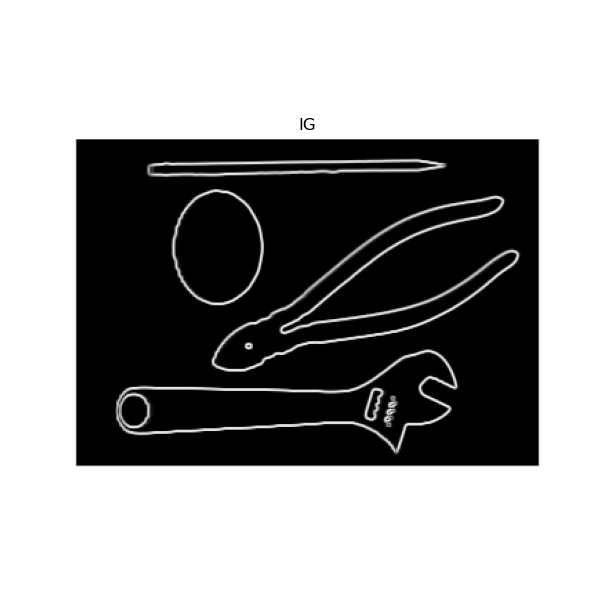

<IPython.core.display.Javascript object>


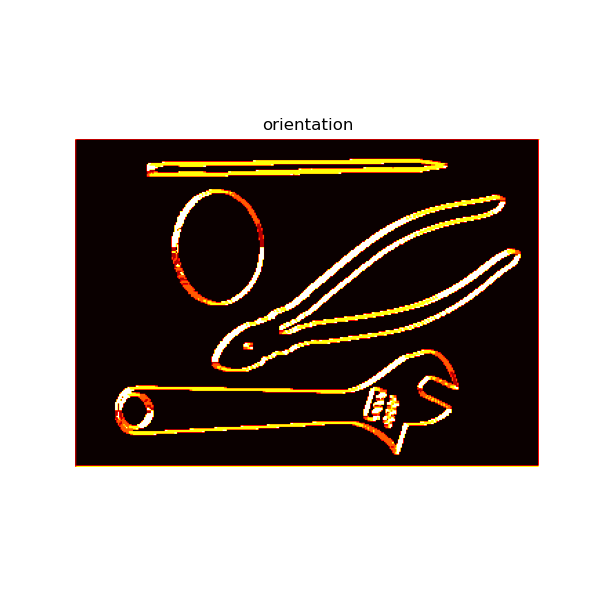

In [6]:
%matplotlib notebook
#### your answer below
tools= np.array(Image.open("img/tools.png"))
Gx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
Gy = Gx.T
Ixt = convolve2d(tools,Gx, "same")
Iyt = convolve2d(tools,Gy, "same")
Igt = np.sqrt(Ixt*Ixt + Iyt*Iyt)
imshow(tools, "tools")
imshow(Igt, "IG")
imshow_hot(orientation(Ixt,Iyt,Igt), "orientation")

Explain the different values given to a pixel by `orientation()`:

Your answer: Pour chaque pixel, la fonction orientation() nous permet d'obtenir la direction du gradiant associé

2. Write a function `G=nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

In [8]:
def nms(Ig, Ior):
    """ Array**2 -> Array """
    n,m=Ig.shape
    J=np.zeros(Ig.shape)
    paddedIg = imagePad(Ig, np.zeros((3,3)))
    for i in range(1, n):
        for j in range(1, m):
            
            orientation = Ior[i-1, j-1]
            
            if orientation == 0:
                continue 
            if orientation == 1: 
                r = paddedIg[i,j+1]
                q = paddedIg[i,j-1]
            if orientation == 2: 
                r = paddedIg[i-1,j+1]
                q = paddedIg[i+1,j-1]
            if orientation == 3: 
                r = paddedIg[i-1,j]
                q = paddedIg[i+1,j]
            if orientation == 4: 
                r = paddedIg[i-1,j-1]
                q = paddedIg[i+1,j+1]
                
            if Ig[i-1,j-1]>=r and Ig[i-1,j-1]>=q :
                J[i-1,j-1] = Ig[i-1, j-1]  
    return J

3. Experiments function `nms()` on images `img/tools.png` and `img/lena.png` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


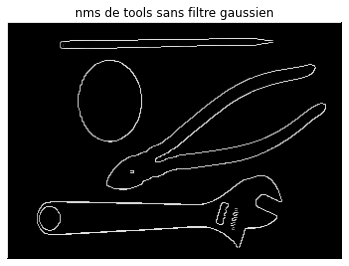

<ipython-input-1-c05621c801a7>:32: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n2 = np.int(3*sigma)


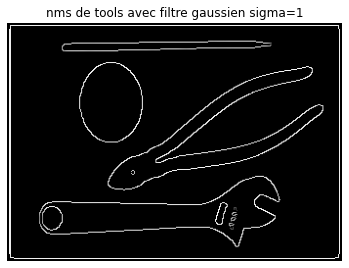

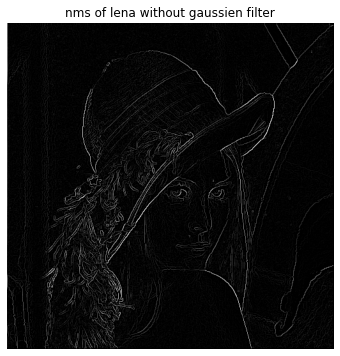

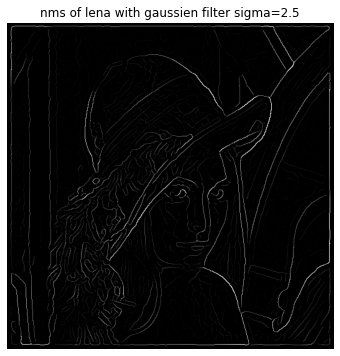

In [10]:
%matplotlib inline
### your answer below

imshow(nms(Igt, orientation(Ixt, Iyt, Igt)),"nms de tools sans filtre gaussien")
sTools = convolve2d(tools,  gaussianKernel(1))
Ixst = convolve2d(sTools,Gx, "same")
Iyst = convolve2d(sTools,Gy, "same")
Igst = np.sqrt(Ixst**2 + Iyst**2)
imshow(nms(Igst, orientation(Ixst, Iyst, Igst)),"nms de tools avec filtre gaussien sigma=1")

Gx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
Gy = Gx.T

Ixl = convolve2d(lena,Gx, "same")
Iyl = convolve2d(lena,Gy, "same")
Igl = np.sqrt(Ixl**2 + Iyl**2)


imshow(nms(Igl, orientation(Ixl, Iyl, Igl)),"nms of lena without gaussien filter")

# sLena = convolve2d(lena,  gaussianKernel(0.5))
# Ixsl = convolve2d(sLena,Gx, "same")
# Iysl = convolve2d(sLena,Gy, "same")
# Igsl = np.sqrt(Ixsl**2 + Iysl**2)
# imshow(nms(Igsl, orientation(Ixsl, Iysl, Igsl)),"nms of lena with gaussien filter sigma=0.5")

sLena = convolve2d(lena,  gaussianKernel(2.5))
Ixsl = convolve2d(sLena,Gx, "same")
Iysl = convolve2d(sLena,Gy, "same")
Igsl = np.sqrt(Ixsl**2 + Iysl**2)
imshow(nms(Igsl, orientation(Ixsl, Iysl, Igsl)),"nms of lena with gaussien filter sigma=2.5")

4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

Le lissage permet alors d'atténuer l'impact du bruit sur les processus de détection de contours. Par ailleurs, on observe que pour $\sigma$ petit, les petits contours (sur le visage par exemple) sont plus nets, alors que pour $\sigma$ grand, les gros contours (comme le mur derrière à gauche) sont plus nets

## Exercice 3:  Effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.png`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

In [13]:
sLena = convolve2d(lena,  gaussianKernel(2), mode="same")

2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

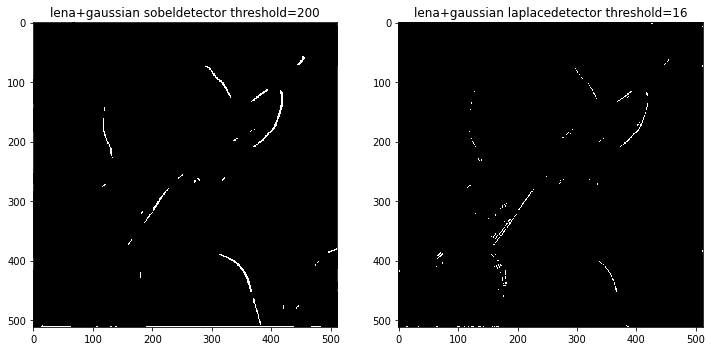

In [16]:
niceDisplay14([SobelDetector(sLena,200),LaplacianDetector(sLena,16)],["lena+gaussian sobeldetector threshold=200","lena+gaussian laplacedetector threshold=16"])

Après le lissage avec $\sigma = 2$ , on observe que du bruit sur la détection de contour est fortement diminué mais que les détecteurs ne retournent pas tous les contours. On peut voir aussi que pour le laplacien l'application du filtre a permis de diminuier tres grandement le threshold, et d'avoir un tres grand ecart de threshold entre les deux detecteur pour un resultat similaire.

3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

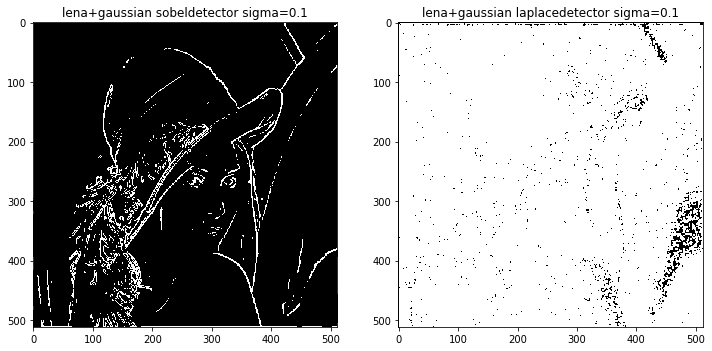

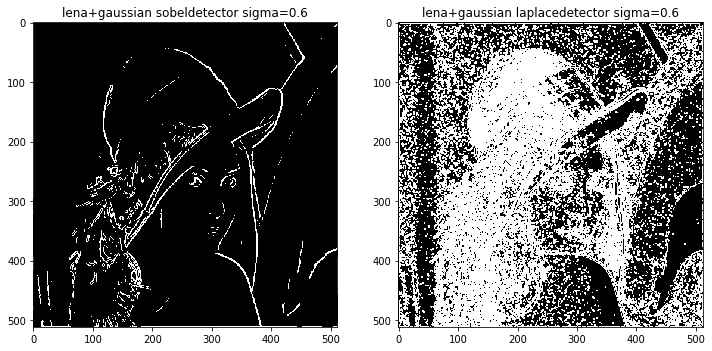

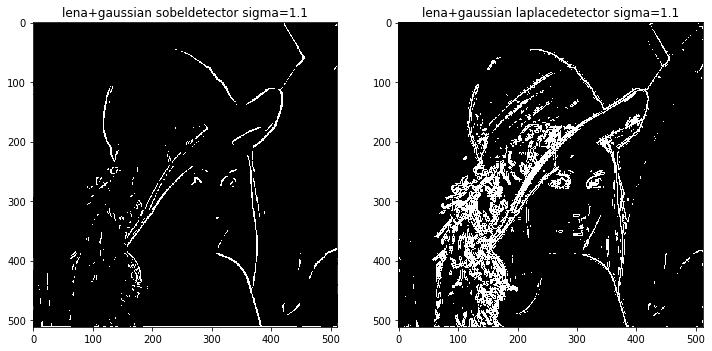

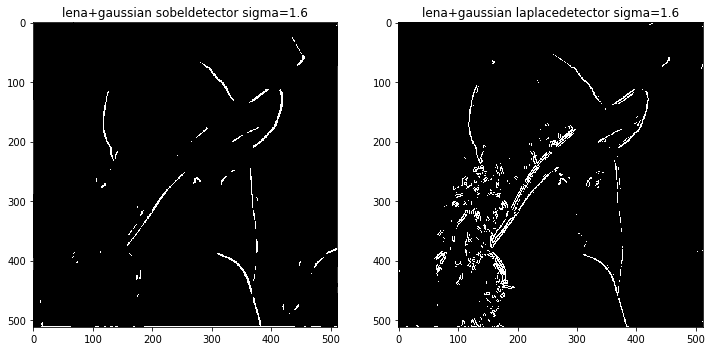

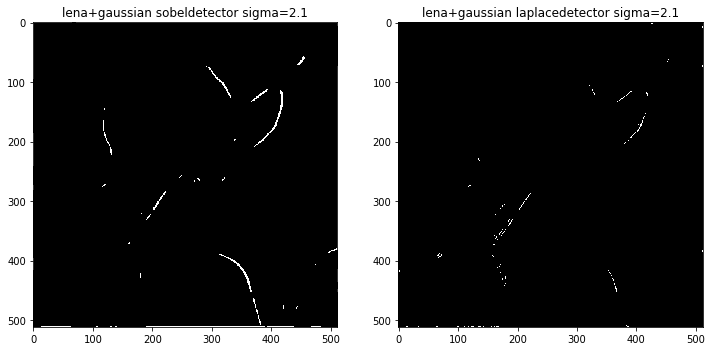

In [17]:
Lisgma=np.arange(0.1, 2.6, 0.5)
for s in Lisgma:
    lena_smooth_s=convolve2d(lena,gaussianKernel(s),"same")
    niceDisplay14([SobelDetector(lena_smooth_s,200),LaplacianDetector(lena_smooth_s,16)],["lena+gaussian sobeldetector sigma="+str(s),"lena+gaussian laplacedetector sigma="+str(s)])

The larger sigma is, the more the impact of noise on the contour detection process is attenuated. However, a value of $\sigma$ that is too large leads to a loss of information. Indeed, we observe that the detectors return less and less contours.
For $\sigma\in[0.1, 2.5]$, we observe that when $\sigma < 1$ or $\sigma > 2$, the Sobel filter returns more contours than the Laplacian.

We also observe that the Laplacian filter is much more sensitive to the sigma variation than the Sobel filter.
Indeed, for $sigma < 1$, the Laplacian filter is strongly impacted by the noise, while for $sigma > 2$, it detects very few contours.

4. Replace the gaussian filter by a constrast enhancer filter. Discuss the results

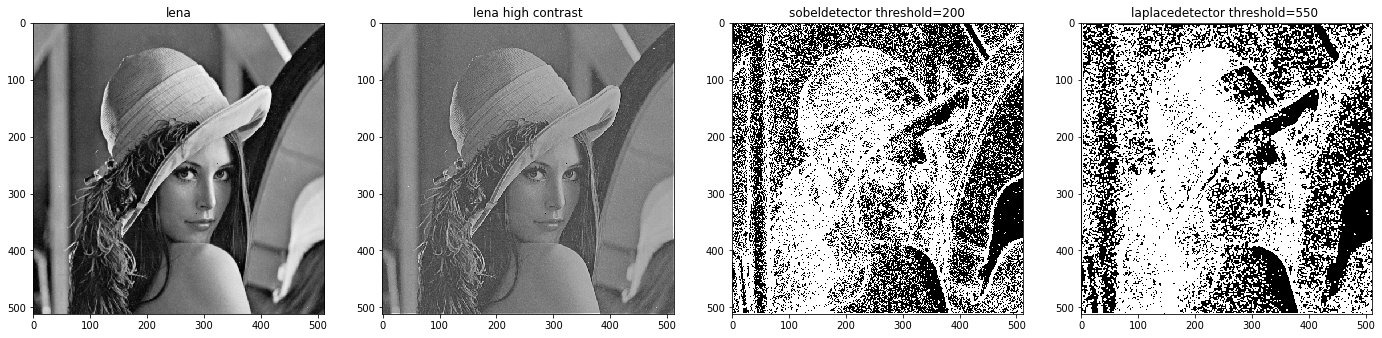

In [23]:
Filtre_Haut=np.array([[-1,-1,-1],[-1, 12,-1],[-1,-1,-1]])
lena_smooth_high=convolve2d(lena,Filtre_Haut,"same")
niceDisplay14([lena,lena_smooth_high,SobelDetector(lena_smooth_high,200),LaplacianDetector(lena_smooth_high,550)],["lena","lena high contrast","sobeldetector threshold=200","laplacedetector threshold=550 "])

Using a Gaussian kernel with $\sigma = 2$ in order to mitigate the effects of noise on the detectors, it was necessary to use respectively thresholds of 200 and 16 for the Sobel and Laplacian detectors so that they detect the same contours. 
We observe that by increasing the contrast of the image, and thus the intensity of the noise, using a high pass filter, for a threshold still at 200 for the Sobel detector, a threshold of 550 is needed with the Laplacian so that the two detectors detect approximately the same contours.

This confirms the fact that the Laplacian is more sensitive to noise.


5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

In [26]:
def multiresolution(I,t):
    """Array*int->None
        affiche la multiresolution decomposition avec l'application des filtres jusqu'à la taille t*t
    """
    I0=I
    n=int(np.log(I.shape[1]/t)/np.log(2))
    niceDisplay14([I0, I0, SobelDetector(I0,200),LaplacianDetector(I0,16)],["lena","lena size²="+str(int(I.shape[1])),"sobel 200","laplace 16 "])
    for k in range(n):
        gs=convolve2d(I0,gaussianKernel(2),"same")
        I1=subSample2(gs)
        I0=I1
        niceDisplay14([I, I1, SobelDetector(I1,200),LaplacianDetector(I1,16)],["lena","lena size²="+str(int(I.shape[1]/(2**(k+1)))),"sobeldetector threshold=200","laplacedetector threshold=16 "])


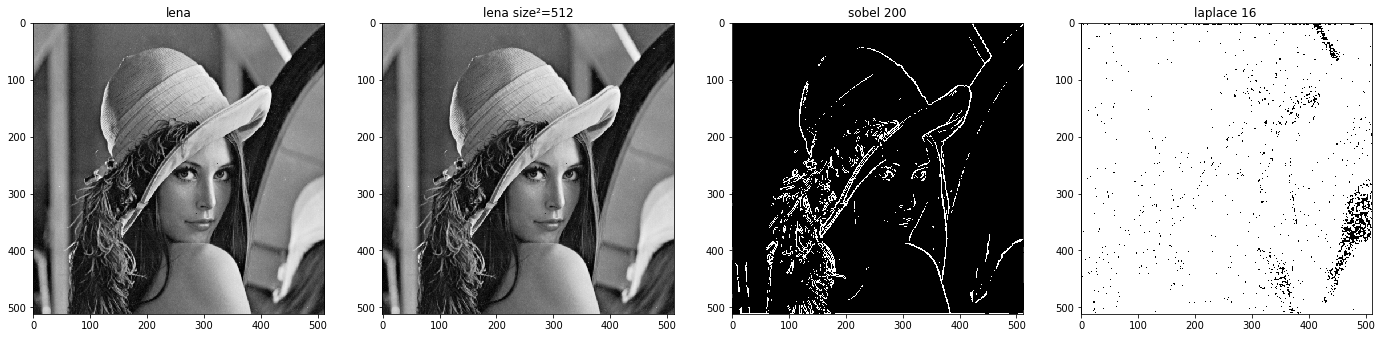

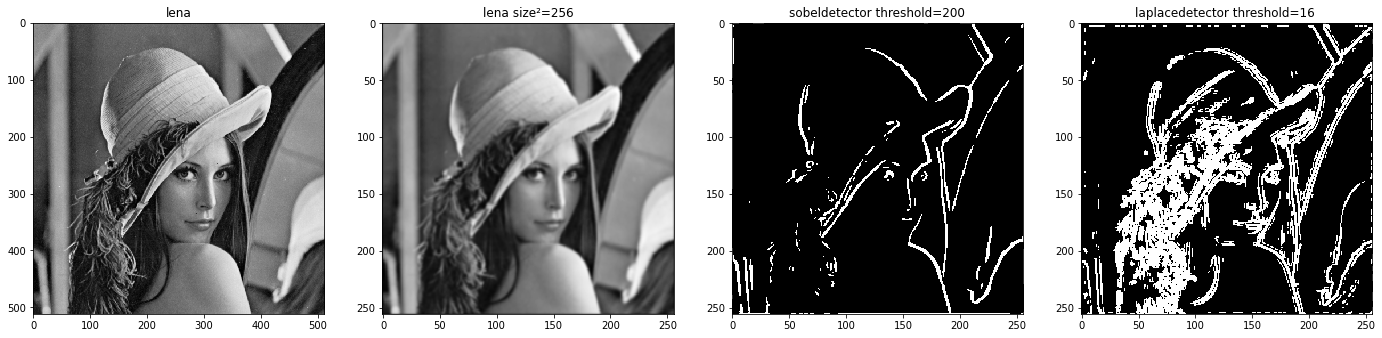

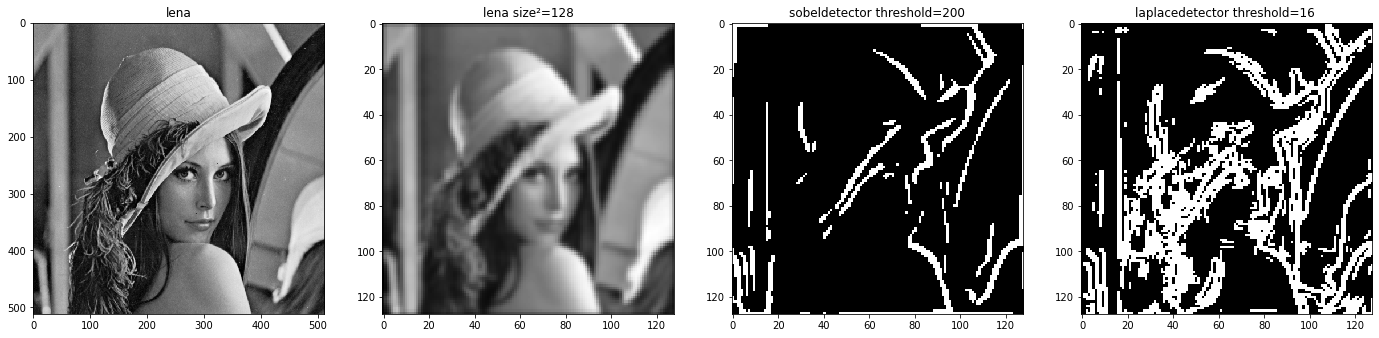

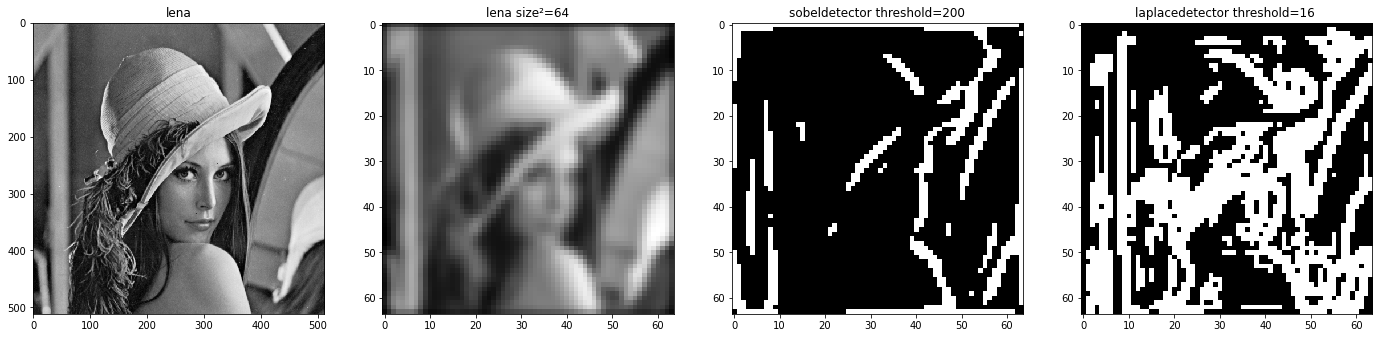

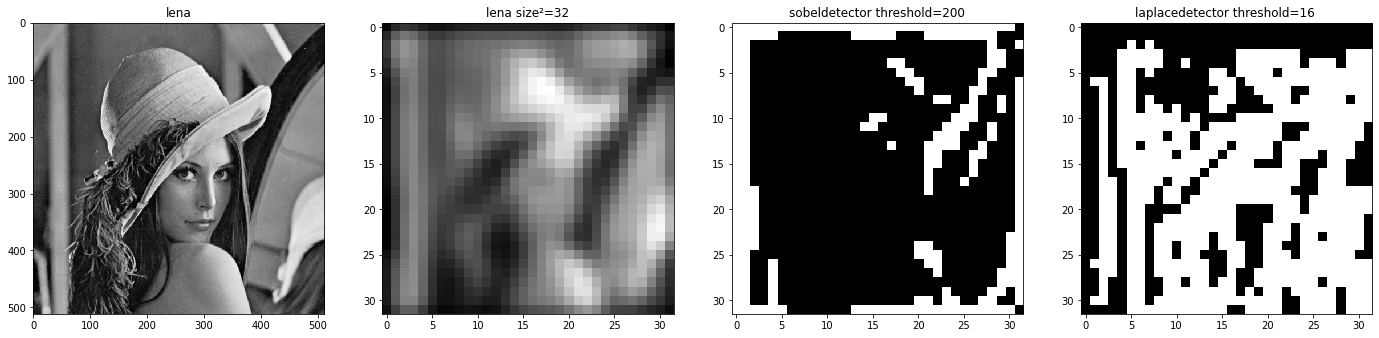

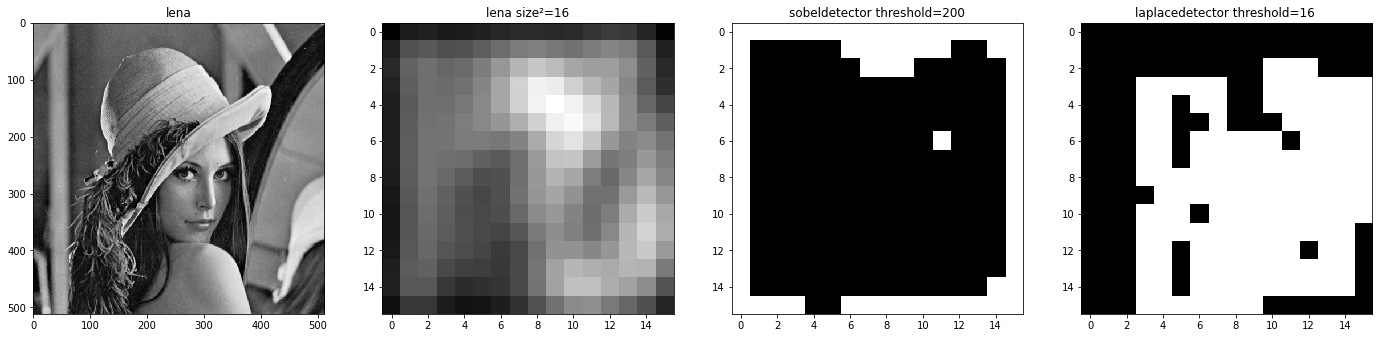

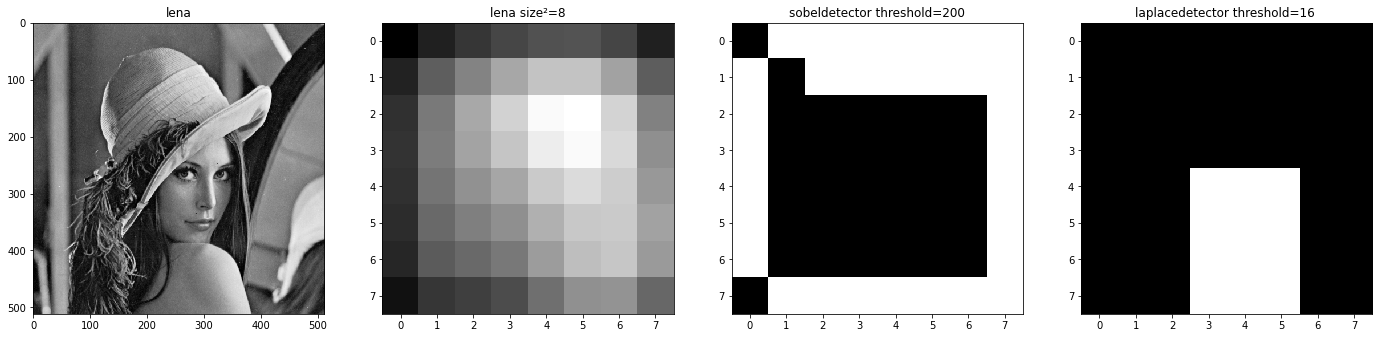

In [27]:
multiresolution(lena,8)

We observe that as subsampling proceeds, the Laplacian seems to be more tolerant than the Sobel detector. Indeed, the Laplacian returns more edges.